In [104]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
reg_path = "all_registration.csv"
reg_header = ["day", "date", "time", "user_id", "action", "born", "phone", "country", "acquired_from"]
registration = pd.read_csv(reg_path, delimiter=';', names = reg_header)
registration["date"] = pd.to_datetime(registration["date"])

free_path = "all_free_tree.csv"
free_tree = pd.read_csv(free_path, delimiter=';', names =["day", "date", "user_id", "action"])

super_path = "all_super_tree.csv"
super_tree = pd.read_csv(super_path, delimiter=';', names =["day", "date", "user_id", "action"])

In [106]:
reg_super = registration.merge(super_tree, how="inner", left_on="user_id", right_on="user_id")
super_sent_by_user = reg_super.groupby("user_id").count()[["acquired_from"]].rename(columns={"acquired_from": "super_sent"})
free_super_sent_users = super_sent_by_user[super_sent_by_user["super_sent"] == 1].reset_index()

paid_super_sent_users = super_sent_by_user.copy().rename(columns={"super_sent": "paid_super_sent"})
paid_super_sent_users["paid_super_sent"] = paid_super_sent_users["paid_super_sent"] - 1
paid_super_sent_users = paid_super_sent_users[paid_super_sent_users.paid_super_sent > 0].reset_index()

In [107]:
reg_free = registration.merge(free_tree, how="inner", left_on="user_id", right_on="user_id")
active_users = reg_free.merge(paid_super_sent_users, how="left", left_on="user_id", right_on="user_id")
active_free_users = active_users[active_users.paid_super_sent.isna()].groupby("user_id").count()[["paid_super_sent"]].reset_index()

In [108]:
free_users = registration.merge(active_free_users, how="inner", left_on="user_id", right_on="user_id")
free_super_users = registration.merge(free_super_sent_users, how="inner", left_on="user_id", right_on="user_id")
paid_users = registration.merge(paid_super_sent_users, how="inner", left_on="user_id", right_on="user_id")

In [109]:
revenue_by_day = paid_users.groupby("date")[["paid_super_sent"]].sum().reset_index().rename(columns={"paid_super_sent":"revenue"})
revenue_by_day = revenue_by_day[revenue_by_day.date != "2024-07-11"]
revenue_by_day

,date,revenue
0,2023-10-13,33
1,2023-10-14,20
2,2023-10-15,39
3,2023-10-16,28
4,2023-10-17,56
...,...,...
267,2024-07-06,1337
268,2024-07-07,1236
269,2024-07-08,1478
270,2024-07-09,1439


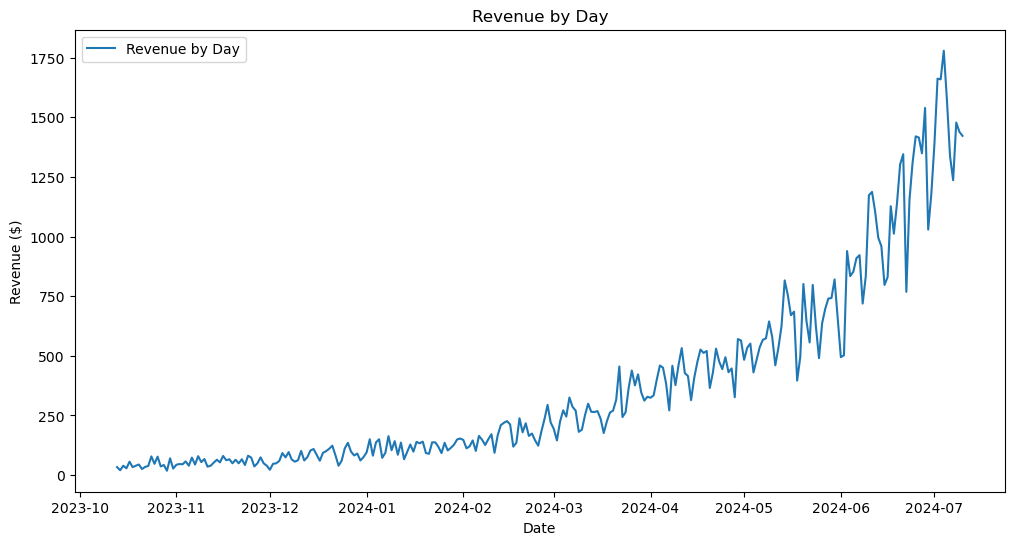

In [110]:
x = revenue_by_day.date
y = revenue_by_day.revenue

plt.figure(figsize=(12, 6)) # You can adjust the width (12) and height (6) as needed
plt.plot(x, y, label="Revenue by Day")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.title("Revenue by Day")
plt.legend()
plt.show()

In [111]:
from datetime import timedelta

last_day = revenue_by_day.date.max()
last_week = last_day - timedelta(days=7)

last_week_revenue = revenue_by_day[revenue_by_day.date > last_week]
last_week_revenue

,date,revenue
265,2024-07-04,1779
266,2024-07-05,1574
267,2024-07-06,1337
268,2024-07-07,1236
269,2024-07-08,1478
270,2024-07-09,1439
271,2024-07-10,1422


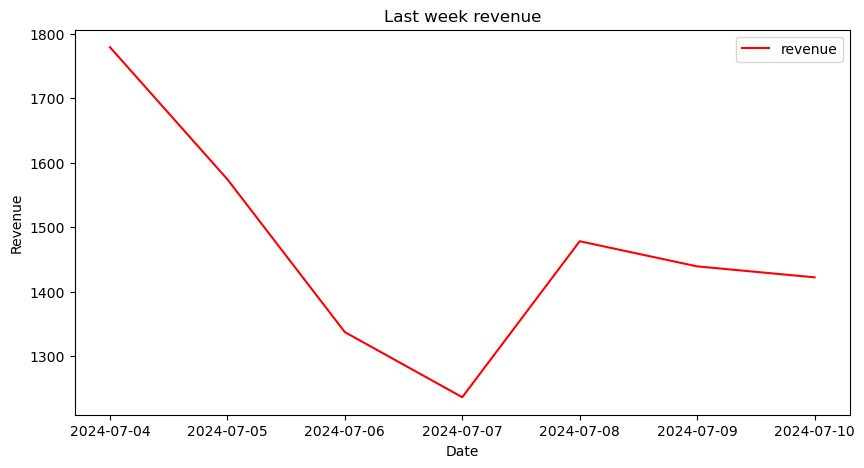

In [112]:
x = last_week_revenue.date
y = last_week_revenue.revenue

lwday = last_day - timedelta(days=6)
if revenue_by_day[revenue_by_day.date == lwday].revenue.item() > revenue_by_day[revenue_by_day.date == last_day].revenue.item():
    szin="red"
else:
    szin="green"

plt.figure(figsize=(10,5))
plt.plot(x, y, label="revenue", color=szin)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Last week revenue")
plt.legend()
plt.show()

In [113]:
print(f"Weekly revenue: {last_week_revenue.revenue.sum()}$")

Weekly revenue: 10265$


In [114]:
daily_revenue = paid_users.groupby("date")[["paid_super_sent"]].sum().rename(columns={"paid_super_sent":"revenue"})
weekly_revenue = daily_revenue.resample("W").sum().reset_index()
weekly_revenue

,date,revenue
0,2023-10-15,92
1,2023-10-22,259
2,2023-10-29,336
3,2023-11-05,327
4,2023-11-12,391
5,2023-11-19,426
6,2023-11-26,411
7,2023-12-03,329
8,2023-12-10,504
9,2023-12-17,593


In [115]:
today_revenue = revenue_by_day[revenue_by_day.date == revenue_by_day.date.max()]["revenue"].item()
print(f"Today's revenue: {today_revenue} $")

Today's revenue: 1422 $


In [116]:
total_revenue = paid_super_sent_users.paid_super_sent.sum()
print(f"Total Revenue: {total_revenue:,}$")

Total Revenue: 101,207$


In [117]:
paid_source = paid_users.groupby("acquired_from")[["paid_super_sent"]].sum(numeric_only="True").reset_index()
paid_invite = paid_source[paid_source.acquired_from == "invite_a_friend"].rename(columns={"paid_super_sent": "revenue"})
paid_invite

,acquired_from,revenue
2,invite_a_friend,89129


In [118]:
rev = paid_invite["revenue"].item()
print(f"Total Revenue from invite_a_friend: {rev:,}$")

Total Revenue from invite_a_friend: 89,129$
